# Using the Jacobi Algorithm to compute the Eigenvalues and Eigenvectors for Quantum Systems

## Numerical Solution Functions

In [7]:
import numpy as np
from numpy.linalg import norm
from scipy.stats import unitary_group

def off(M):
    rows = M.shape[0]
    columns = M.shape[1]
    sum0 = 0
    for i in range(rows):
        for k in range(columns):
            if(i != k):
                sum0 += abs(M[i, k])**2
    return sum0**(1/2)


def splitMatrix(M):
    return M.real, M.imag


#The numerical method used to diagonalize a matrix
#p and q are integers limited by: 1 <= p < q <= n
def jacobiRotation(M, p, q):
    c = 0
    s = 0
    if M[p, q] != 0:
        tau = (M[q, q] - M[p, p]) / (2 * M[p, q])
        if tau >= 0:
            t = 1/(tau + (1 + tau**2)**(1/2))
        else:
            t = 1/(tau - (1 + tau**2)**(1/2))
        c = 1/((1 + t**2)**(1/2))
        s = t * c
    else:
        c = 1
        s = 0
    J = np.identity(M.shape[0])
    J[p, p] = c
    J[p, q] = s
    J[q, p] = -s
    J[q, q] = c
    return J
               

def real_eigen(M, tolerance):
    n = M.shape[0]
    R = np.identity(n)
    delta = tolerance*(norm(M))
    while off(M) > delta:
        for p in range(0, n-1):
            for q in range(p + 1, n):
                J = jacobiRotation(M, p, q)
                M = (J.transpose().dot(M)).dot(J)
                R = R.dot(J)
    d = np.array([M[i, i] for i in range(n)])
    return d, R
    
def complex_eigen(H, tolerance):
    S, A = splitMatrix(H)
    
    O1 = np.concatenate((S, A), axis=0)
    O2 = np.concatenate((-A, S), axis=0)
    O = np.concatenate((O1, O2), axis=1)
    
    dd, R = real_eigen(O, tolerance)
    
    rRows = R.shape[0]
    U0 = np.zeros((int(rRows / 2), int(rRows)), dtype=complex)
    for i in range(0, rRows):
        U0[:, i] = R[:int(rRows/2), i] + (R[int(rRows/2):, i]*1j)
    
    index = np.argsort(dd)
    dd = dd[index]
    U0 = U0[:, index]
    
    d = np.array([dd[i] for i in range(0, len(dd), 2)])
    U = np.zeros((int(rRows / 2), int(rRows/2)), dtype=complex)
    
    for i in range(0, rRows,2):
        if norm(U0[:,i] > U0[:,i+1]):
            U[:,int(i/2)] = U0[:,i]
        else:
            U[:,int(i/2)] = U0[:,i+1]
    return d, U

def hermitian_eigensystem(H, tolerance):
    
    """ Solves for the eigenvalues and eigenvectors of a hermitian matrix
    
    Args:
        H: Hermitian matrix for which we want to compute eigenvalues and eigenvectors
        
        tolerance: A number that sets the tolerance for the accuracy of the computation.  This number
        is multiplied by the norm of the matrix H to obtain a number delta.  The algorithm successively
        applies (via similarity transformation) Jacobi rotations to the matrix H until the sum of the
        squares of the off-diagonal elements are less than delta.
    
    
    
    Returns:
        d: Numpy array containing eigenvalues of H in non-decreasing order
        
        U: A 2d numpy array whose columns are the eigenvectors corresponding to the computed
        eigenvalues.
        
        
    Checks you might need to do:
        
        H * U[:,k] = d[k] *　U[:,k]      k=0,1,2,...,(n-1)
        
        d[0] <= d[1] <= ... <= d[n-1]     (where n is the dimension of H)
       
        np.transpose(U) * U = U * np.transpose(U) = np.eye(n)
        
    """
    
    d, U = complex_eigen(H, tolerance)
    index = np.argsort(d)
    d = d[index]
    U = U[:, index]
        
    
    return d, U

#Creates a Hermitian matrix of size n x n and returns the matrix along with its exact eigenvalues
def createHermitian(n):
    p = unitary_group.rvs(n)
    b = np.random.randint(-2000,2000,size=(n))
    arr = np.diag(b)
    herm = np.matrix(p).dot(arr).dot(np.matrix(p).H)
    diag = np.diag(herm).real
    np.fill_diagonal(herm,diag)
    return herm, b


### Numerical Solution Tests

The numerical solutions are tested by first comparing the computed eigenvalues to the exact eigenvalues (Matrices with known eigenvalues are used). 

Next, the accuracy of the numerical solution is tested by ensuring the following equation holds true:

\begin{equation}
Av = \lambda v
\end{equation}

where A is the hermitian matrix, v is the eigenvector, and $\lambda$ is the corresponding eigenvalue.


Lastly, the following equation is checked to ensure that the numerical solution is accurate:

\begin{equation}
U^\dagger U = U U^\dagger
\end{equation}

where U is the computed eigenvector matrix.

The accuracy of these tests should be within the tolerance specified when calling the hermitian_eigensystem function. In this case it is 0.01.


In [8]:
n = 2
herm, b = createHermitian(n)
tolerance = 0.1
d, U = hermitian_eigensystem(herm, 0.01)

print("FOR HERMITIAN MATRIX SIZE: ", n)
print("Eigenvalues from createHermitian function:", b)
print("Eigenvalues from numerical solution:", d)
print("\n")

for i in range(n):
    print("Hermitian matrix * Eigenvector {0}: ".format(i + 1), np.array(herm.dot(U[:,i])).reshape(n,))
    print("Eigenvalue {0} * Eigenvector {0}:     ".format(i + 1), d[i] * U[:, i])
    print("\n")
    

print("Hermitian of U * U: ", "\n", (U.conj().transpose().dot(U)))
print("U * Hermitian of U: ", "\n", U.dot(U.conj().transpose()))

FOR HERMITIAN MATRIX SIZE:  2
Eigenvalues from createHermitian function: [-363 1178]
Eigenvalues from numerical solution: [-363. 1178.]


Hermitian matrix * Eigenvector 1:  [-322.1528 +34.7693j  -36.3207-159.5572j]
Eigenvalue 1 * Eigenvector 1:      [-322.1528 +34.7693j  -36.3207-159.5572j]


Hermitian matrix * Eigenvector 2:  [ -35.3833+529.8574j 1050.22   -52.1641j]
Eigenvalue 2 * Eigenvector 2:      [ -35.3833+529.8574j 1050.22   -52.1641j]


Hermitian of U * U:  
 [[ 1.0000e+00-5.5320e-18j -6.9389e-17-5.5511e-17j]
 [-6.9389e-17+0.0000e+00j  1.0000e+00+3.0014e-18j]]
U * Hermitian of U:  
 [[ 1.0000e+00+0.0000e+00j -4.8572e-17-2.2204e-16j]
 [-4.8572e-17+2.2204e-16j  1.0000e+00+0.0000e+00j]]


Slight variations of the tests are then ran for multiple matrices of different sizes.

In [9]:
nums = [3, 5, 10, 15, 20, 30]
%precision 4
for n in nums:
    herm, b = createHermitian(n)
    tolerance = 0.001
    d, U = hermitian_eigensystem(herm, tolerance)

    print("FOR HERMITIAN MATRIX SIZE: ", n)
    print("Eigenvalues from createHermitian function:", "\n", b)
    print("Eigenvalues from numerical solution:", "\n", d)
    print("\n")

    for i in range(n):
        norm1 = np.linalg.norm(np.array(herm.dot(U[:,i])).reshape(n,) - d[i] * U[:, i])
        norm2 = np.linalg.norm(np.array(herm.dot(U[:,i])).reshape(n,))
        print("Standardized Norm of (Hermitian matrix * Eigenvector {0}) - (Eigenvalue {0} * Eigenvector {0}): ".format(i + 1), "\n", abs(norm1/norm2))

    
    print("\n")
    print("Norm of off-diagnoal elements of Hermitian of U * U: ", "\n", off(U.conj().transpose().dot(U)))
    print("Norm of off-diagnoal elements of U * Hermitian of U: ", "\n", off(U.dot(U.conj().transpose())), "\n", "\n", "---------------------------------------------", "\n")

FOR HERMITIAN MATRIX SIZE:  3
Eigenvalues from createHermitian function: 
 [  863  1283 -1320]
Eigenvalues from numerical solution: 
 [-1320.   863.  1283.]


Standardized Norm of (Hermitian matrix * Eigenvector 1) - (Eigenvalue 1 * Eigenvector 1):  
 6.0297600054270875e-06
Standardized Norm of (Hermitian matrix * Eigenvector 2) - (Eigenvalue 2 * Eigenvector 2):  
 4.116071455196522e-07
Standardized Norm of (Hermitian matrix * Eigenvector 3) - (Eigenvalue 3 * Eigenvector 3):  
 5.700736441668461e-06


Norm of off-diagnoal elements of Hermitian of U * U:  
 2.831451674637223e-06
Norm of off-diagnoal elements of U * Hermitian of U:  
 2.6666513371484775e-06 
 
 --------------------------------------------- 

FOR HERMITIAN MATRIX SIZE:  5
Eigenvalues from createHermitian function: 
 [ 1294  -232  -580 -1059  1652]
Eigenvalues from numerical solution: 
 [-1059.      -580.      -232.      1294.      1651.9999]


Standardized Norm of (Hermitian matrix * Eigenvector 1) - (Eigenvalue 1 * Eigen

FOR HERMITIAN MATRIX SIZE:  30
Eigenvalues from createHermitian function: 
 [-1566 -1851   524 -1854  1951    11 -1858  1442  -609  1630 -1791   323
 -1593 -1636  1846  1172  1148   578  1950   301  -790  -582  1785  -451
  -577 -1594  -533  1211   322    28]
Eigenvalues from numerical solution: 
 [-1857.9734 -1854.0025 -1851.0774 -1791.0059 -1636.0073 -1594.0048
 -1593.0165 -1566.      -790.      -609.      -582.      -577.
  -533.      -451.        11.        28.       301.       322.
   323.       524.       578.      1148.      1172.      1211.
  1442.      1629.9994  1785.      1846.      1949.9997  1950.9941]


Standardized Norm of (Hermitian matrix * Eigenvector 1) - (Eigenvalue 1 * Eigenvector 1):  
 0.0017540070999773473
Standardized Norm of (Hermitian matrix * Eigenvector 2) - (Eigenvalue 2 * Eigenvector 2):  
 0.00024097716517337397
Standardized Norm of (Hermitian matrix * Eigenvector 3) - (Eigenvalue 3 * Eigenvector 3):  
 0.0005004875280560246
Standardized Norm of (Hermiti

## Analyzing the Anharmonic Oscillator

The Hamiltonian that governs the anharmonic oscillator is:

\begin{equation}
\hat{H}_\lambda = \hat{H}_0 + \lambda \hat{x}^4
\end{equation}

where $\hat{H}_\lambda$ is the complete hamiltonian, $\hat{H}_0$ is the hamiltonian for the harmonic oscillator, and $\lambda$ is the anharmonic coefficient.

In [14]:
import matplotlib.pyplot as plt

#Returns the coefficient of the expanded <n|x^2|m>
def getCoeff2(n, m):
    if n == m:
        return (n + 0.5)
    elif n == m - 2:
        return (0.5) * ((n + 1) * (n + 2))**(0.5)
    elif n == m + 2:
        return (0.5) * ((n -1) * n)**(0.5)
    else:
        return 0

#Returns the coefficient of the expanded <n|x^4|m>
def getCoeff4(n, m, upperLimit):
    sum0 = 0
    for i in range(upperLimit + 1):
        sum0 += getCoeff2(n, i) * getCoeff2(i, m)
    return sum0

#Returns the eigenvalues and eigenvector matrix of the anharmonic oscillator
def solveAnharmonic(n, coeff):
    M = np.zeros((n, n), dtype = complex)
    for i in range(n):
        for k in range(n):
            if i == k:
                M[i, k] = (0.5 + k) + (coeff * (getCoeff4(i, k, n)))
            else:
                M[i , k] = (coeff * (getCoeff4(i, k, n)))
                
    d, U = hermitian_eigensystem(M, 0.01)
    return d, U

#Calculates the energies of the first four quantum numbers based on the lambda value used
def getEnergies(lamNum, size):
    firstEnergies = np.zeros((lamNum, 4), dtype=float)
    lambdas = np.linspace(0, 1, num=lamNum)
    for l in range(lamNum):
        d, U = solveAnharmonic(size, lambdas[l])
        firstEnergies[l, :] = d[:4]
    return firstEnergies

### Energy Observations

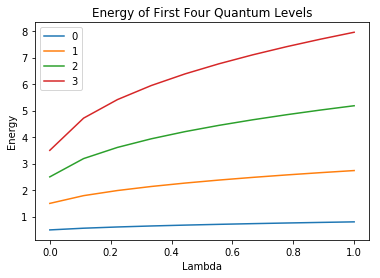

In [19]:
firstEnergies = getEnergies(10, 20)

lambdas = np.linspace(0, 1, num=10)
for i in range(4):
    plt.plot(lambdas, firstEnergies[:, i])
    

plt.legend(("0", "1", "2", "3"))
plt.xlabel("Lambda")
plt.ylabel("Energy")
plt.title("Energy of First Four Quantum Levels")
plt.show()

As the system becomes more anharmonic (increasing lambda value), the more energy it has for the relative quantum level. The increase in energy becomes more dramatic as the quantum level increases.

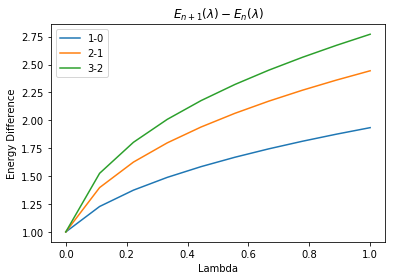

In [22]:
differences = np.zeros((firstEnergies.shape[0], firstEnergies.shape[1] - 1), dtype = float)
for i in range(3):
    differences[:, i] = firstEnergies[:, i + 1] - firstEnergies[:, i]
    plt.plot(lambdas, differences[:, i])

    
plt.legend(("1-0", "2-1", "3-2"))
plt.xlabel("Lambda")
plt.ylabel("Energy Difference")
plt.title("$E_{n+1}(\lambda) - E_n(\lambda)$")
plt.show()

The difference in energy between adjacent quantum levels increases as (1) lambda increases and (2) as the compared quantum levels increase.

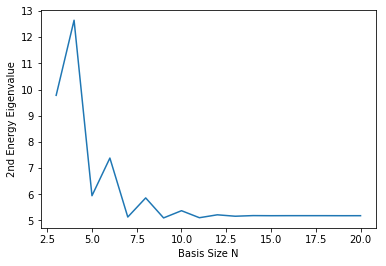

In [23]:
def getEnergiesN(nMax, numE):
    energies = np.zeros((numE, nMax - numE), dtype = float)
    n = np.arange(numE + 1, nMax + 1)
    for i in range(len(n)):
        d, U = solveAnharmonic(n[i], 1)
        energies[:, i] = d[1:numE + 1]
    return energies, n

energies, n = getEnergiesN(20, 2)

plt.plot(n, energies[1,:])
plt.xlabel("Basis Size N")
plt.ylabel("2nd Energy Eigenvalue")
plt.title("Energy vs Basis Size")
plt.show()

Here, it can be seen that as the basis size of the matrix increases, the 2nd energy value for the anharmonic oscillator ($\lambda$ = 1) converges to around 5. The larger the basis used, the more accurate the result.

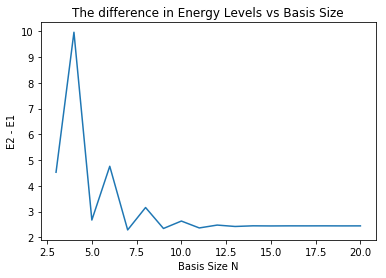

In [30]:
differences = energies[1,:] - energies[0,:]
plt.plot(n, differences)
plt.xlabel("Basis Size N")
plt.ylabel("E2 - E1")
plt.title("The difference in Energy Levels vs Basis Size")
plt.show()

The plot above illustrates how the difference between the second and first energy values converges as the basis size increases. Again, the larger basis size gives more accurate results.

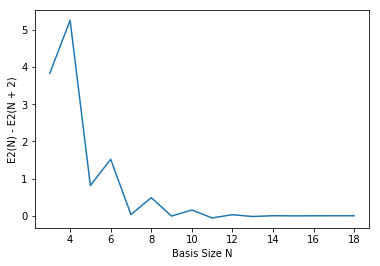

In [25]:
differences = np.array([energies[1, i] - energies[1, i + 2] for i in range(len(n) - 2)])

plt.plot(n[:16], differences)
plt.xlabel("Basis Size N")
plt.ylabel("E2(N) - E2(N + 2)")
plt.title("Energy Difference Between Different Basis Sizes")
plt.show()

The plot above shows that difference between in the second level energy value between a basis of size N and a basis of size N+2 converges to 0. This signifies that at large N, changing the basis size won't affect the energy eigenvalue at a significant level.

### Illustrating the Eigenfunctions

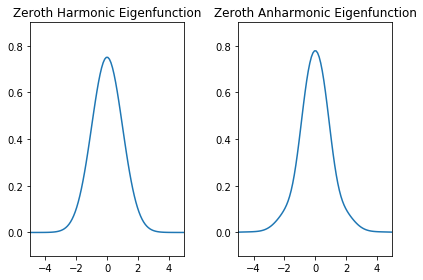

In [26]:
import math

#The exact solution for the harmonic oscillator
def eigenFunction(x, n, hFunc):
    coeff = ((2**n) * (math.factorial(n)) * ((np.pi)**(0.5)))**(-0.5)
    return coeff * np.exp(-(x**2)/(2)) * hFunc(x, n)

def hFunction(x, n):
    if n == 0:
        return 1
    if n == 1:
        return x * 2
    return (2 * x * hFunction(x, n - 1)) - (2 * n * hFunction(x, n - 2))



xvals = np.linspace(-5, 5, num = 100)
plt.subplot(1, 2, 1)
plt.plot(xvals, eigenFunction(xvals, 0, hFunction))
plt.title("Zeroth Harmonic Eigenfunction")
plt.axis([-5, 5, -.1, 0.9])

size = 20
d, U = solveAnharmonic(size, 1)
yvals = np.zeros(xvals.shape, dtype=float)
for i in range(size):
    x = 0.0
    if U[i, 0].real > U[i, 0].imag:
        x = U[i, 0].real
    else:
        x = U[i, 0].imag
    yvals += x * eigenFunction(xvals, i, hFunction)
plt.subplot(1, 2, 2)
plt.plot(xvals, yvals)
plt.title("Zeroth Anharmonic Eigenfunction")
plt.axis([-5, 5, -.1, .9])

plt.tight_layout()
plt.show()

It can be seen above that for the zeroth order eigenfunction, the harmonic and anharmonic eigenfunctions are very similar.

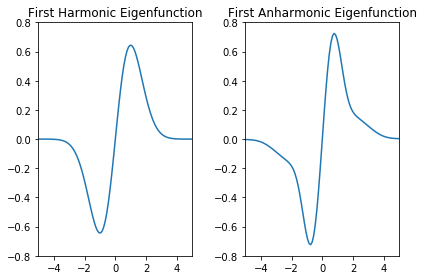

In [27]:
plt.subplot(1, 2, 1)
plt.plot(xvals, eigenFunction(xvals, 1, hFunction))
plt.title("First Harmonic Eigenfunction")
plt.axis([-5, 5, -.8, 0.8])


yvals = np.zeros(xvals.shape, dtype=float)
for i in range(size):
    x = 0.0
    if U[i, 1].real > U[i, 1].imag:
        x = U[i, 1].real
    else:
        x = U[i, 1].imag
    yvals += x * eigenFunction(xvals, i, hFunction)

plt.subplot(1, 2, 2)
plt.plot(xvals, yvals)
plt.title("First Anharmonic Eigenfunction")
plt.axis([-5, 5, -.8, 0.8])

plt.tight_layout()
plt.show()

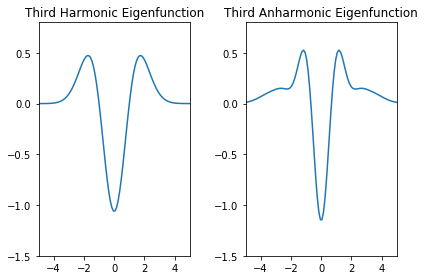

In [28]:
plt.subplot(1, 2, 1)
plt.plot(xvals, eigenFunction(xvals, 2, hFunction))
plt.title("Third Harmonic Eigenfunction")
plt.axis([-5, 5, -1.5, 0.8])

yvals = np.zeros(xvals.shape, dtype=float)
for i in range(size):
    x = 0.0
    if U[i, 2].real > U[i, 2].imag:
        x = U[i, 2].real
    else:
        x = U[i, 2].imag    
    yvals += x * eigenFunction(xvals, i, hFunction)
plt.subplot(1, 2, 2)
plt.plot(xvals, yvals)
plt.title("Third Anharmonic Eigenfunction")
plt.axis([-5, 5, -1.5, 0.8])

plt.tight_layout()
plt.show()

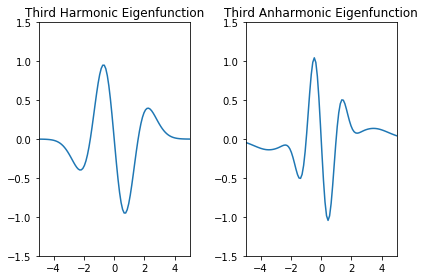

In [29]:
plt.subplot(1, 2, 1)
plt.plot(xvals, eigenFunction(xvals, 3, hFunction))
plt.title("Third Harmonic Eigenfunction")
plt.axis([-5, 5, -1.5, 1.5])

yvals = np.zeros(xvals.shape, dtype=float)
for i in range(size):
    x = 0.0
    if U[i, 3].real > U[i, 3].imag:
        x = U[i, 3].real
    else:
        x = U[i, 3].imag    
    yvals += x * eigenFunction(xvals, i, hFunction)
plt.subplot(1, 2, 2)
plt.plot(xvals, yvals)
plt.title("Third Anharmonic Eigenfunction")
plt.axis([-5, 5, -1.5, 1.5])

plt.tight_layout()
plt.show()

As the order of the eigenfunction increases, the differences between the harmonic solution and the anharmonic solution become more noticeable.